# Human Classification using HOG Features

### Imports

In [72]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from skimage import io
from skimage import feature
from skimage import img_as_float
from skimage.transform import resize
from skimage.color import rgba2rgb
from skimage.exposure import rescale_intensity

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

### Utility Functions

In [28]:
def show(img):
    """
    Nothing to show
    """
    io.imshow(img)
    plt.show()

In [71]:
def gallery(collection, labels=None, indices=None, nrows=1, ncols=3, k=6):
    """
    Display a random nrows x ncols gallery from collection.
    """
    if indices is None:
        indices = len(collection)

    rng = np.random.default_rng()

    fig, ax = plt.subplots(nrows, ncols, figsize=(k*nrows, k*ncols), squeeze=False)

    for r in range(nrows):
        for c in range(ncols):
            i = rng.choice(indices, replace=False)
            img = collection[i]
            ax[r][c].imshow(img)
            if labels is not None:
                ax[r][c].set_title(labels[i])

    fig.tight_layout()
    plt.show()

In [30]:
def plot_confusion_matrix(y_true, y_pred, classes=None, normalize=False, k=3):
    """
    Display confusion matrix as a heatmap.
    """
    cm = confusion_matrix(y_true, y_pred)
    r, c = cm.shape

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    df = pd.DataFrame(cm)

    if classes:
        df.columns = classes
        df.index = classes

    fig, ax = plt.subplots(figsize=(k*r, k*c))
    ax = sns.heatmap(df, annot=True, cmap='YlGnBu')

    plt.show()

In [73]:
def load_images_from_folder(folder, shape):
    """
    Load all images from a folder and resize to 'shape'.
    """
    images = []
    for filename in os.listdir(folder):
        path = os.path.join(folder,filename)
        img = img_as_float(io.imread(path))

        if img.shape[2] == 4:
            img = rgba2rgb(img)

        img = resize(img, shape, anti_aliasing=True)

        images.append(img)

    return np.array(images)

In [32]:
def load_data(main_dir, class_dirs, class_labels, shape, train=False):
    """
    Load images from a directory containing one folder for each class.
    """
    images = []
    labels = []

    for class_dir, class_label in zip(class_dirs, class_labels):
        path = main_dir + class_dir
        imgs = load_images_from_folder(path, shape)
        images.append(imgs)
        labels += [class_label] * len(imgs)

    images = np.vstack(images)
    labels = np.array(labels, dtype=object)
    
    if train:
        images, labels = shuffle(images, labels)

    return images, labels

### Load data

In [31]:
TRAIN_DIR = './inria_dataset/Train/'
TEST_DIR = './inria_dataset/Test/'

CLASSES = ['Human', 'Not Human']
CLASS_DIRS = ['pos/', 'neg/']

SHAPE = (128, 64)

In [69]:
train_images, train_labels = load_data(TRAIN_DIR, CLASS_DIRS, CLASSES, SHAPE, train=True)
print(train_images.shape)
print(train_labels.shape)

(3634, 128, 64, 3)
(3634,)


In [84]:
test_images, test_labels = load_data(TEST_DIR, CLASS_DIRS, CLASSES, SHAPE, train=False)
print(test_images.shape)
print(test_labels.shape)

(1585, 128, 64, 3)
(1585,)


Dataset visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


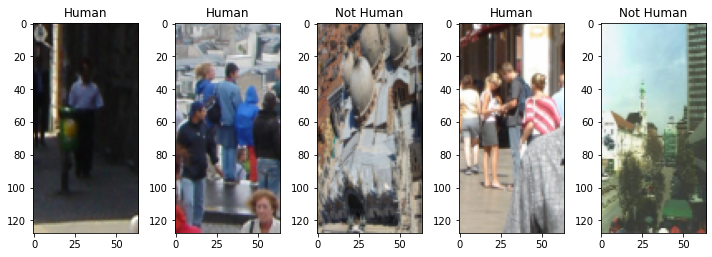

In [74]:
gallery(train_images, labels=train_labels, ncols=5, k=10)

### HOG Feature Extraction

In [75]:
def hog(img):
    """
    Compute HOG descriptor for an image.
    """
    fd, himg = feature.hog(
        img,
        orientations=8,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        multichannel=True,
        visualize=True
    )

    return fd, himg

def batch_hog(collection):
    """
    Compute HOG descriptors for a collection of images.
    """
    fds = []
    himgs = []

    for img in collection:
        fd, himg = hog(img)
        fds.append(fd)
        himgs.append(himg)

    return np.array(fds), np.array(himg)

HOG feature visualization

Human


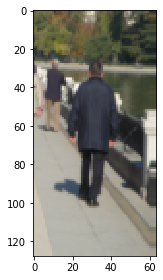

(3360,)


/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


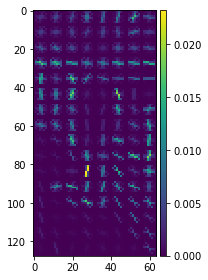

In [79]:
print(train_labels[0])
show(train_images[0])

fd, himg = hog(train_images[0])
print(fd.shape)
# Rescale histogram for better display
himg = rescale_intensity(himg, in_range=(0, 10))
show(himg)

### Prepare dataset for training

In [80]:
le = LabelEncoder()
le.fit(CLASSES)

LabelEncoder()

In [81]:
def preprocess(images, labels, label_encoder):
    """
    Convert images and labels to features and class indices.
    """
    x, _ = batch_hog(images)
    y = label_encoder.transform(labels)

    return x, y

In [82]:
x_train, y_train = preprocess(train_images, train_labels, le)
print(x_train.shape)
print(y_train.shape)

(3634, 3360)
(3634,)


### SVM Classification

In [83]:
clf = SVC()
clf.fit(x_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Random Forest Classification

In [109]:
clf = RandomForestClassifier()
clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Quantitative Evaluation

In [85]:
x_test, y_test = preprocess(test_images, test_labels, le)
print(x_test.shape)
print(y_test.shape)

(1585, 3360)
(1585,)


In [110]:
y_pred = clf.predict(x_test)
pred_labels = le.inverse_transform(y_pred)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1132
           1       0.79      0.87      0.83       453

    accuracy                           0.90      1585
   macro avg       0.87      0.89      0.88      1585
weighted avg       0.90      0.90      0.90      1585



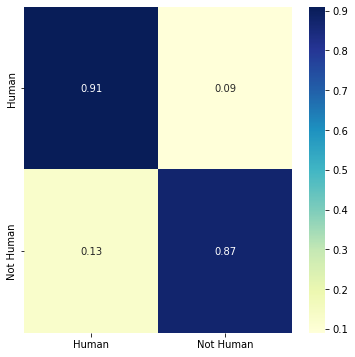

In [111]:
plot_confusion_matrix(y_test, y_pred, classes=CLASSES, normalize=True)

### Qualitative Evaluation

Correctly classified images and their predicted labels.

In [113]:
correct_indices = np.argwhere(y_test == y_pred).flatten()

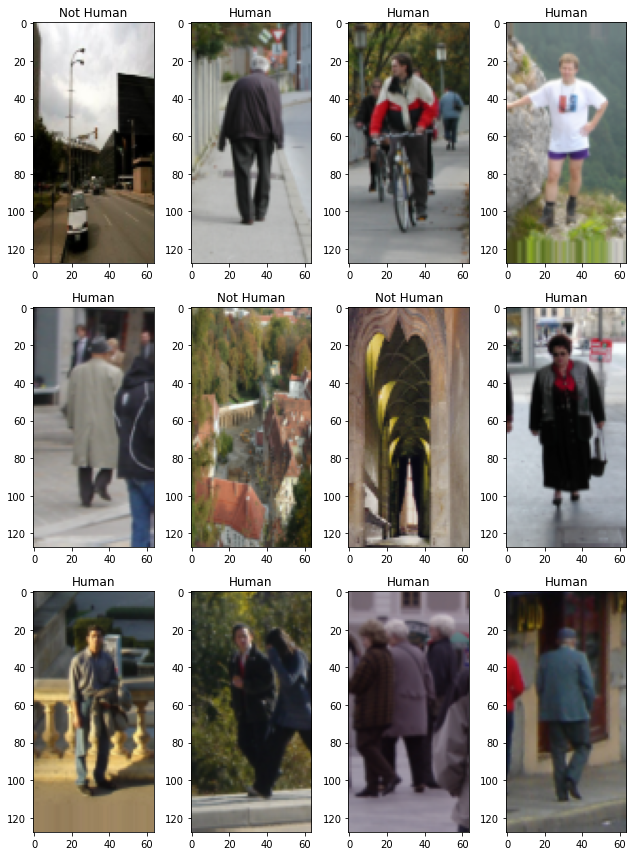

In [114]:
gallery(test_images, labels=pred_labels, indices=correct_indices, nrows=3, ncols=4, k=3)

Incorrectly classified images and their predicted labels.

In [115]:
wrong_indices = np.argwhere(y_test != y_pred).flatten()

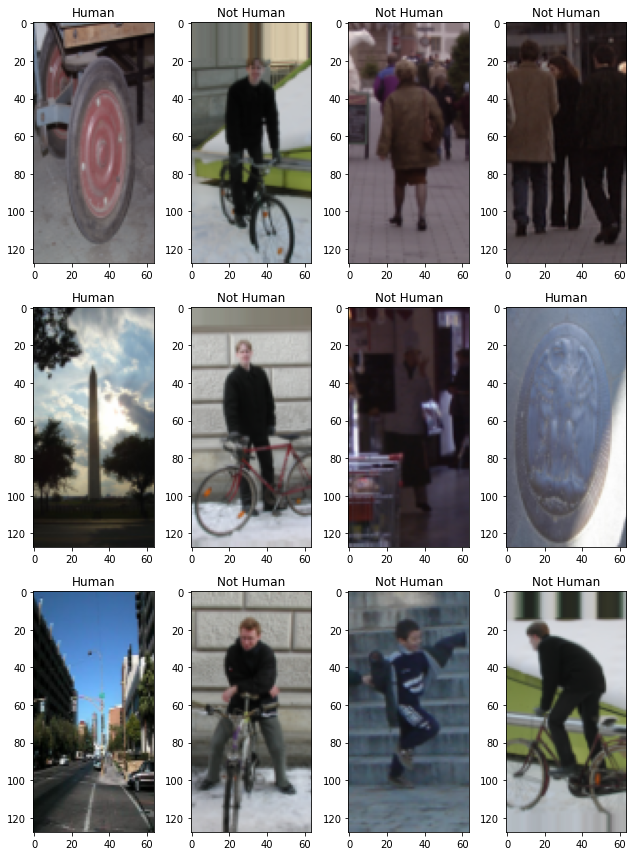

In [116]:
gallery(test_images, labels=pred_labels, indices=wrong_indices, nrows=3, ncols=4, k=3)